## Introduction
This notebook models how late a commercial flight will be.  A flight is considered late if it arrives more than 30 minutes pas its expected arrival time.  Three different methods were used to model this data: k-nearest neighbor, random forest and simple linear regression.

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing

## Import and clean data
The orininal file (2008.csv) is around 700,000 lines of flight information which is far beyond the capacity of my laptop, so when importing the data, we are randomly selecting 30,000 lines to make up the training data (80% of 30,000) and the test data (20% of 20,000).

In [2]:
filename = "2008.csv"
n = sum(1 for line in open('2008.csv')) - 1 #number of records in file (excludes header)
s = 20000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)

In [3]:
df.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,928.0,900,1042.0,1020,WN,96,...,6.0,14.0,0,NaN,0,9.0,0.0,0.0,0.0,13.0
1,2008,1,3,4,943.0,925,1048.0,1035,WN,2646,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,1752.0,1730,1920.0,1855,WN,3159,...,4.0,13.0,0,NaN,0,0.0,0.0,3.0,0.0,22.0
3,2008,1,4,5,1850.0,1755,1920.0,1830,WN,2788,...,3.0,7.0,0,NaN,0,0.0,0.0,0.0,0.0,50.0
4,2008,1,4,5,1946.0,1940,2058.0,2100,WN,3154,...,3.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Next, just checking to see how many NaN values are present for each feature.

In [4]:
df.isnull().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                404
CRSDepTime               0
ArrTime                449
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum                243
ActualElapsedTime      453
CRSElapsedTime           2
AirTime                453
ArrDelay               453
DepDelay               404
Origin                   0
Dest                     0
Distance                 0
TaxiIn                 449
TaxiOut                406
Cancelled                0
CancellationCode     19594
Diverted                 0
CarrierDelay         15679
WeatherDelay         15679
NASDelay             15679
SecurityDelay        15679
LateAircraftDelay    15679
dtype: int64

Some flights have been canceled and we will eliminate these flights from the model since they cannot be late (or early or on-time).  The next line of code captures all of the rows where an arrival delay ('ArrDelay' feature) exists.

In [5]:
df = df[np.isfinite(df['ArrDelay'])]

Check again to look out for NaN values.

In [6]:
df.isnull().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                  0
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum                  0
ActualElapsedTime        0
CRSElapsedTime           0
AirTime                  0
ArrDelay                 0
DepDelay                 0
Origin                   0
Dest                     0
Distance                 0
TaxiIn                   0
TaxiOut                  0
Cancelled                0
CancellationCode     19547
Diverted                 0
CarrierDelay         15226
WeatherDelay         15226
NASDelay             15226
SecurityDelay        15226
LateAircraftDelay    15226
dtype: int64

Next, we need to drop some features that have excessive NaN values and not relevant to the goals of this model. 

In [7]:
# drop NaN values in data
df.drop(['CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
        'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'Diverted', 'Year', 'TailNum'], axis=1, inplace=True)

Finally, checking one last time for NaN values.

In [8]:
df.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
dtype: int64

We now need to check the data types to make sure they are in the correct form before modeling.  As you can see, we have ints, floats and objects.  The objects and ints will need to be converted to floats for sklearn interpretation.

In [9]:
df.dtypes

Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
dtype: object

In [10]:
# list a random sample of 5 rows of the dataset
df.sample(5)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut
8420,5,4,7,1442.0,1445,1613.0,1613,DL,1654,91.0,88.0,71.0,0.0,-3.0,CMH,ATL,446,13.0,7.0
14160,9,5,5,2026.0,2029,2157.0,2155,OO,6458,91.0,86.0,63.0,2.0,-3.0,LAX,TUS,451,6.0,22.0
8457,5,17,6,1430.0,1430,1807.0,1834,DL,424,217.0,244.0,196.0,-27.0,0.0,SJU,ATL,1547,8.0,13.0
14143,9,28,7,1515.0,1515,1730.0,1744,OH,6461,135.0,149.0,95.0,-14.0,0.0,LGA,CHS,641,12.0,28.0
18062,11,1,6,915.0,920,1054.0,1047,9E,2897,99.0,87.0,63.0,7.0,-5.0,ROC,DTW,296,9.0,27.0


The following line just looks at the data in the middle of the dataset for exploring and analyzing.

In [11]:
df.loc[0:300, 'FlightNum':"TaxiIn"].head(5)

,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn
0,96,74.0,80.0,54.0,22.0,28.0,OAK,LAX,337,6.0
1,2646,125.0,130.0,110.0,13.0,18.0,PHX,OAK,646,5.0
2,3159,88.0,85.0,71.0,25.0,22.0,SNA,OAK,371,4.0
3,2788,90.0,95.0,80.0,50.0,55.0,ABQ,LAS,487,3.0
4,3154,72.0,80.0,63.0,-2.0,6.0,JAN,HOU,359,3.0


In [12]:
# print the number of rows and columns of our dataframe
df.shape

(19547, 19)

## Data Exploration
We will look at some basic visualizations to explore the data.

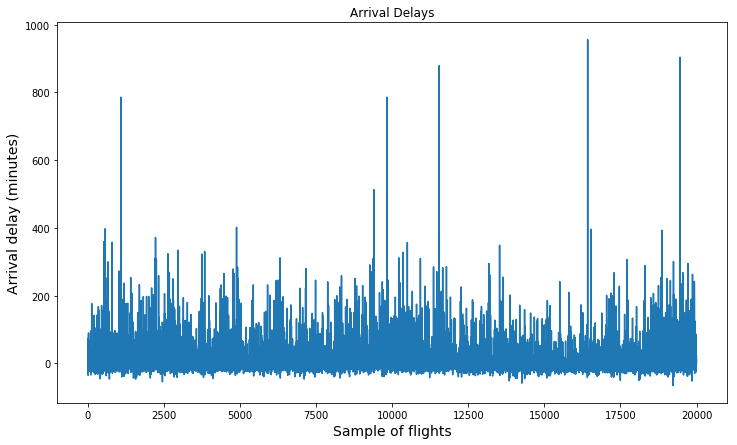

In [13]:
df['ArrDelay'].plot(figsize=(12,7))
plt.title('Arrival Delays')
plt.xlabel('Sample of flights', fontsize=14)
plt.ylabel('Arrival delay (minutes)', fontsize=14)
plt.show()

This shows all of the flights in our data and their corresponding arrival delay times.

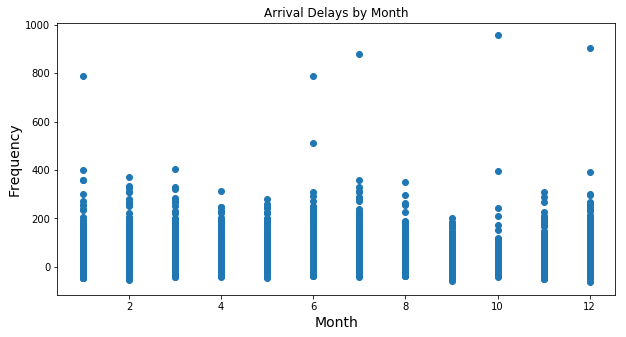

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Month'], df['ArrDelay'])
plt.title('Arrival Delays by Month')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The above plot shows the arrival delay by each month.  It looks like they are fairly evenly dispersed here.

In [15]:
df["ArrDelay"].mean()

8.128817721389472

In [16]:
df.groupby('Month').mean()

,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
Month,,,,,,,,,,,,,,,
1,16.043088,3.826451,1354.784560,1342.849791,1498.196888,1508.889886,2173.940754,127.433872,129.355476,103.878516,9.989228,11.910832,724.482944,6.765410,16.789946
2,14.889820,3.879510,1342.643041,1330.769974,1491.797036,1509.269330,2176.998711,128.664304,129.117912,104.592784,14.460696,14.914304,722.553479,6.889175,17.182345
3,15.926667,4.003636,1338.274545,1327.376364,1485.021212,1496.261818,2181.030303,127.898182,129.115758,104.856364,11.110909,12.328485,728.675758,6.890909,16.150909
4,15.222087,3.797937,1330.022451,1326.479369,1479.322816,1484.401092,2097.353155,129.591626,131.077063,106.669903,6.038228,7.523665,744.516383,6.777913,16.143811
5,16.121123,4.015214,1327.767115,1319.593329,1484.104740,1485.964892,2286.900527,125.875366,127.296080,103.102399,5.910474,7.331188,719.795787,6.591574,16.181393
6,15.689430,3.931710,1322.022565,1311.773753,1455.983967,1477.176960,2196.001188,127.132423,127.386580,102.653207,13.035036,13.289192,722.352732,6.872922,17.606295
7,16.001734,3.879769,1336.104624,1329.390751,1447.314451,1487.168208,2244.209827,127.868786,130.205202,104.085549,10.481503,12.817919,740.525434,6.769942,17.013295
8,15.595460,4.112340,1323.434226,1311.058789,1476.815483,1482.117579,2200.711292,127.781723,130.045984,104.136205,6.502328,8.766589,741.288126,7.126892,16.518626
9,15.323432,3.693729,1319.970297,1317.404620,1486.132013,1500.638944,2097.458086,122.346535,125.425743,99.784818,0.780198,3.859406,705.770957,6.807921,15.753795


From the above queries, we can see that the average arrival delay is about 8.1 minutes and the month with the longest average arrival delay is December - where the average delay is about 17 minutes.

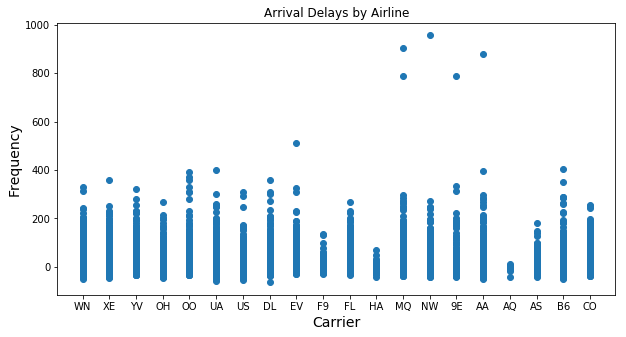

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(df['UniqueCarrier'], df['ArrDelay'])
plt.title('Arrival Delays by Airline')
plt.xlabel('Carrier', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The above scatterplot shows the range of arrival dalays for each carrier.

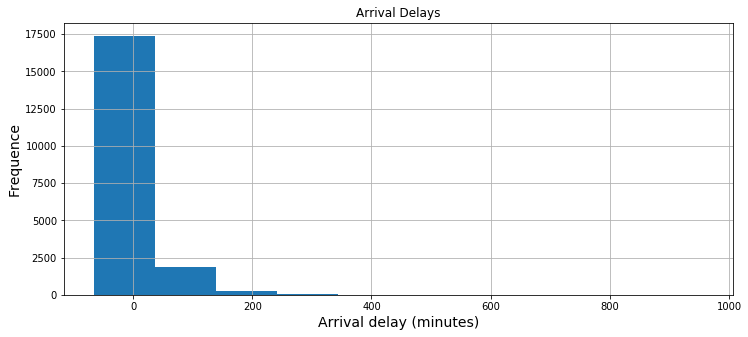

In [18]:
# plot all of the data by unit sales

df.hist(column='ArrDelay', figsize=(12,5))
plt.title('Arrival Delays')
plt.xlabel('Arrival delay (minutes)', fontsize=14)
plt.ylabel('Frequence', fontsize=14)
plt.show()

This histogram shows where most of the arrival delays occur. They are clustered around zero with some higher values skewed to the right.

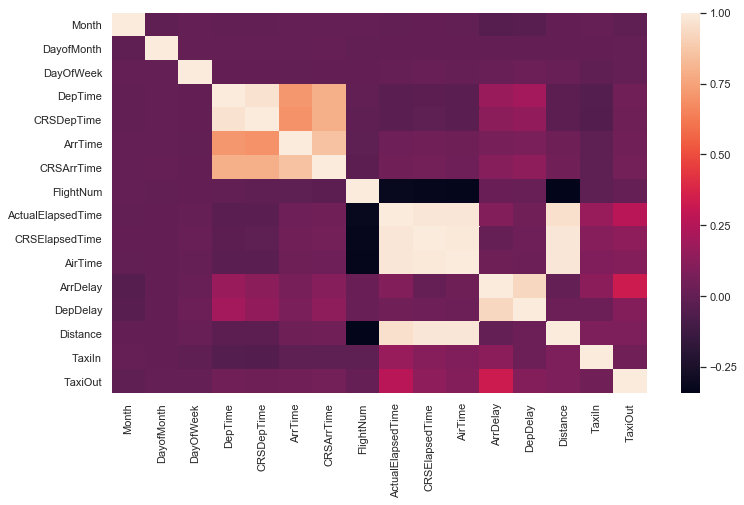

In [19]:
sns.set(font_scale=1.0)
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr())

This heatmap shows the correlation for each feature in our dataset.  We can see that most of the data has a low correlation except for a few obvious examples such as the relationship between departure time and arrival time and between departure delay and arrival delay.

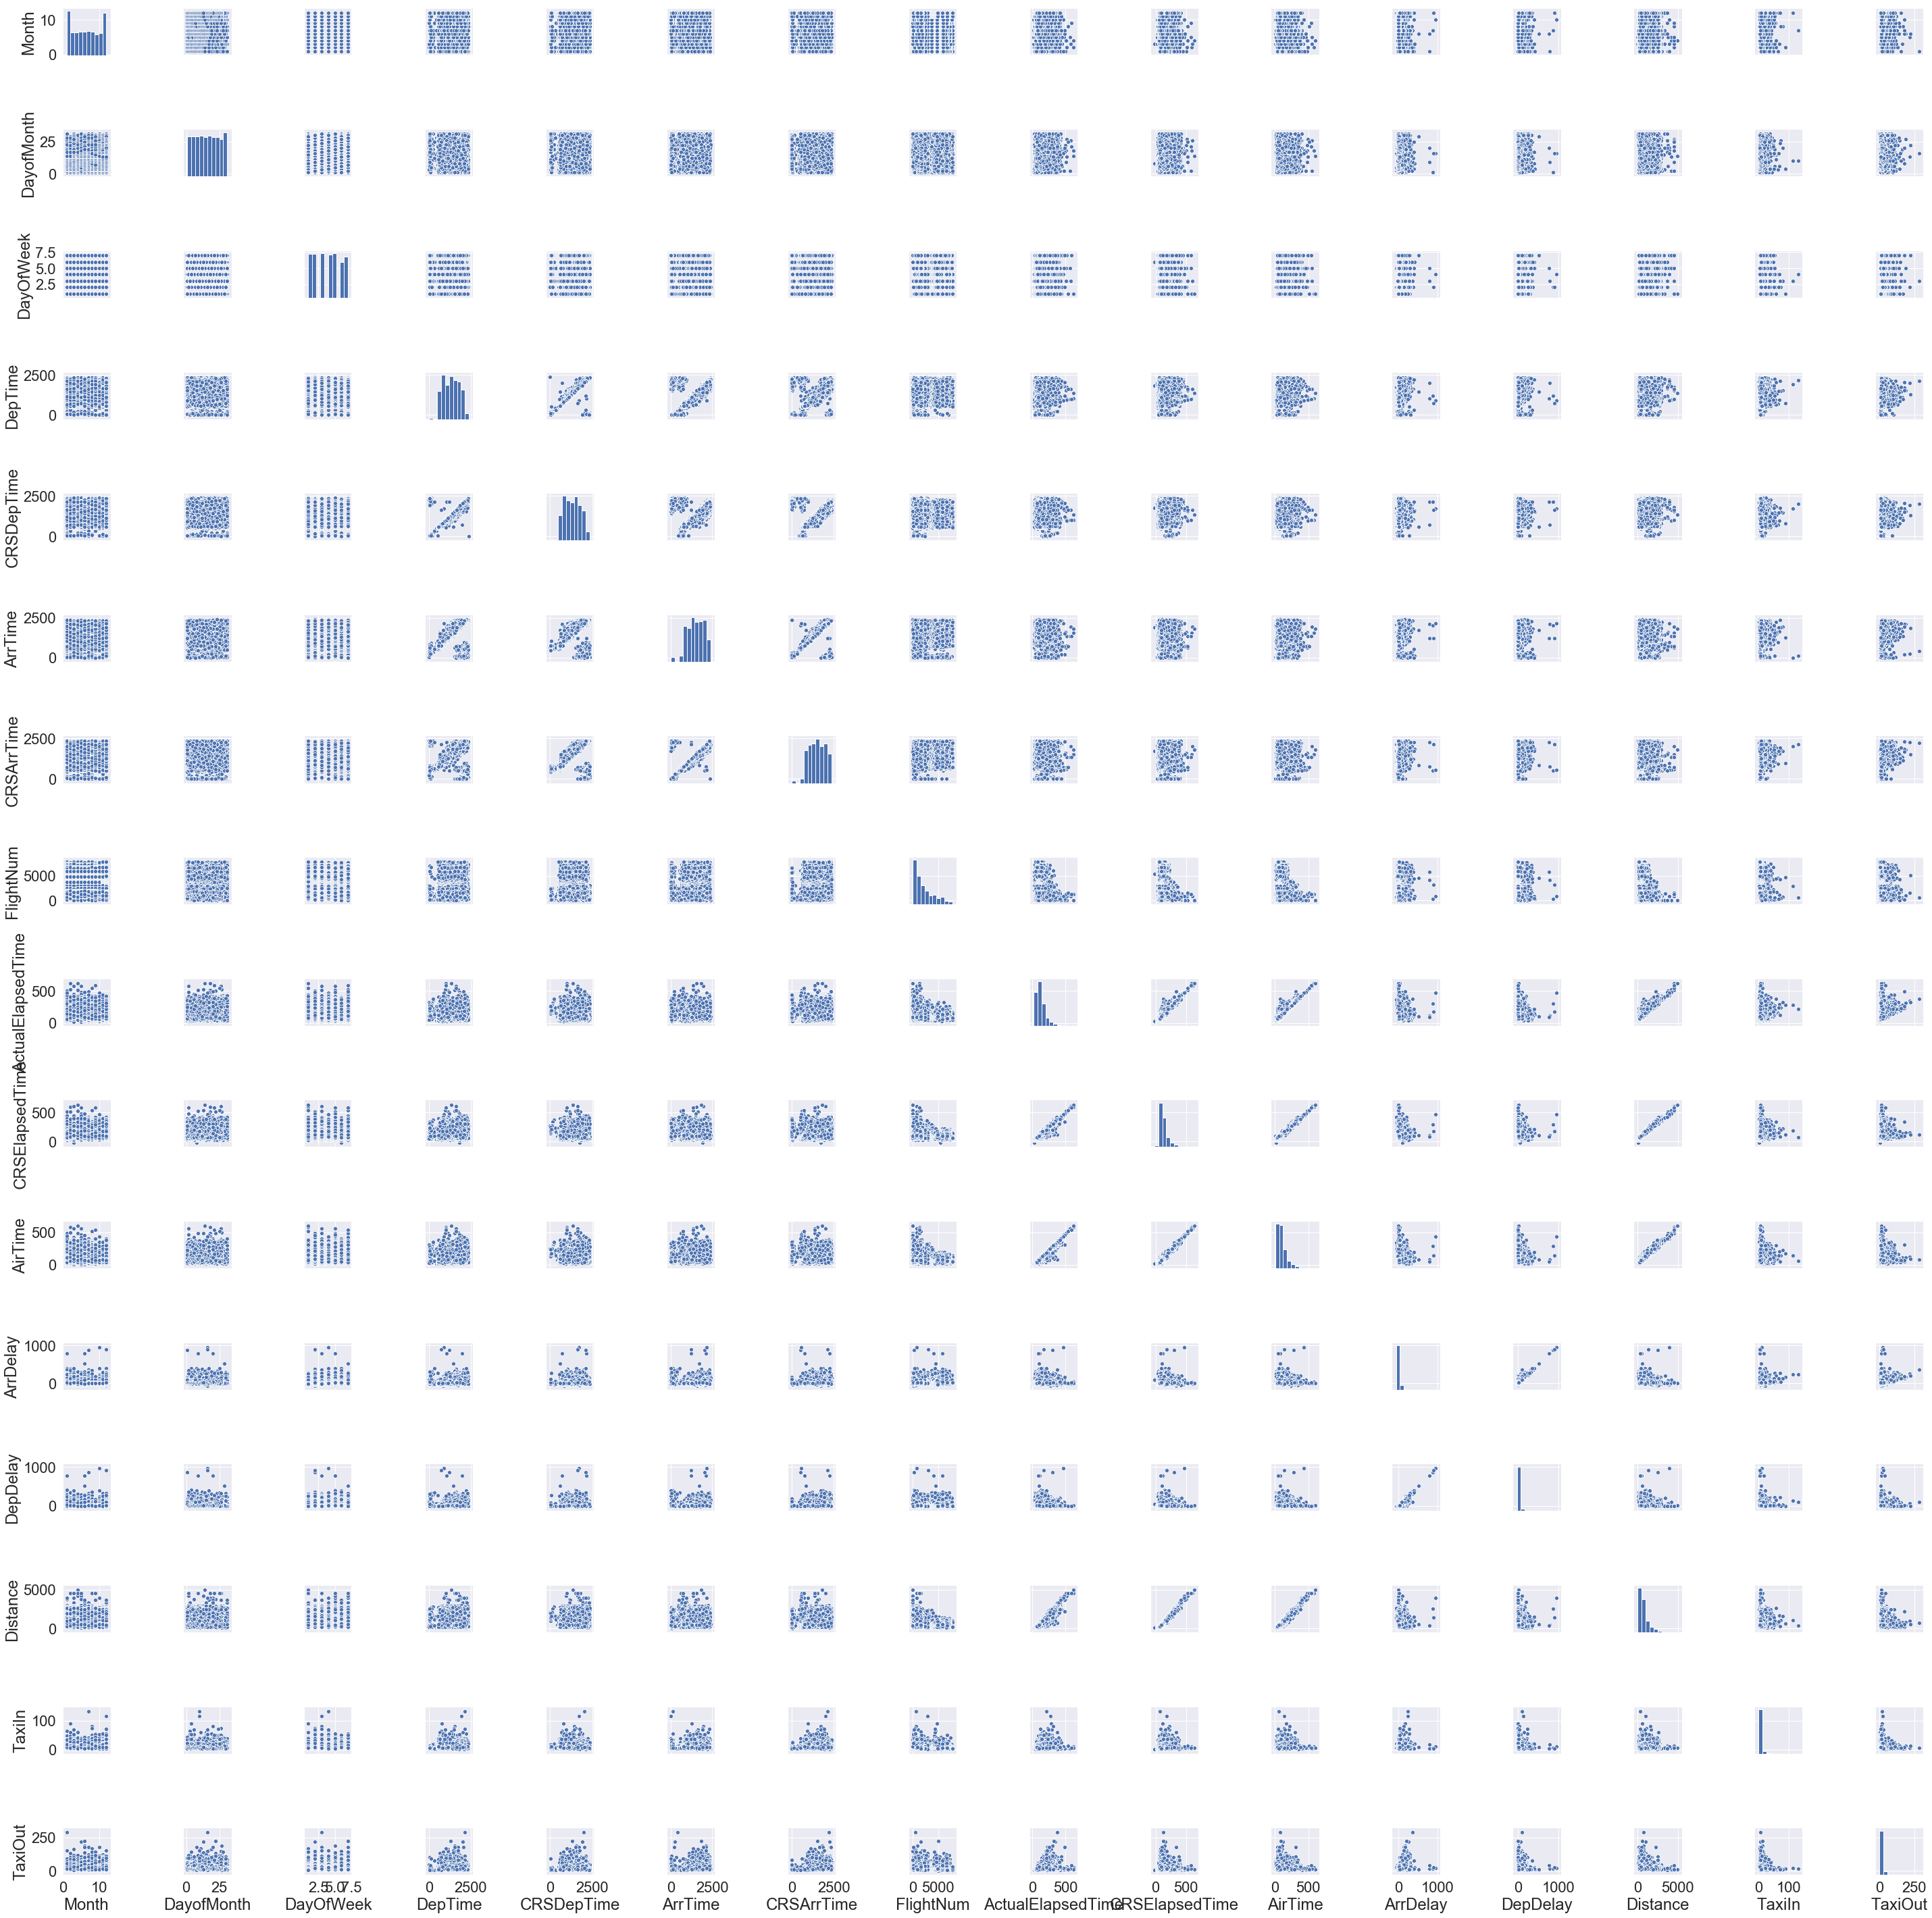

In [20]:
sns.set(font_scale=2.0)
sns.pairplot(df)

The above pairplot shows a more detailed correlation scatterplot between the features of our model.  As you can see, there are stong linear relationships between some features, such as Departure Delay and Arrival Delay.  

The next line of code extracts the Carrier, Origin, and Destination and converts the values to a binary classification.

In [21]:
# convert these 3 features to binary
df = pd.get_dummies(df, columns=['UniqueCarrier', 'Origin', 'Dest'])
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,...,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,1,3,4,928.0,900,1042.0,1020,96,74.0,80.0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4,943.0,925,1048.0,1035,2646,125.0,130.0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,4,1752.0,1730,1920.0,1855,3159,88.0,85.0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,5,1850.0,1755,1920.0,1830,2788,90.0,95.0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,5,1946.0,1940,2058.0,2100,3154,72.0,80.0,...,0,0,0,0,0,0,0,0,0,0


Next, list the new shape of our dataframe after the binary conversion.

In [22]:
df.shape

(19547, 597)

Normalize the data, convert to float and shuffle data for modeling.

In [23]:
# normalize data
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

# convert data to float type
df = df.astype(float)

# shuffle dataframe before modeling
df = df.sample(frac=1)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,...,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
10466,0.051540,-0.453734,-0.152845,-0.115766,-0.119299,-0.064454,-0.070980,0.085644,0.042964,0.054746,...,-0.000102,-0.000205,-0.000256,-0.001586,-0.000153,-0.00087,-0.001995,-0.000051,-0.000051,-0.000409
3637,-0.312096,0.412933,0.180488,-0.004470,0.001566,0.051844,0.052006,-0.239002,0.063031,0.062368,...,-0.000102,-0.000205,-0.000256,-0.001586,-0.000153,-0.00087,-0.001995,-0.000051,-0.000051,-0.000409
6704,-0.221187,-0.220400,-0.152845,0.081400,0.086384,0.063516,0.061336,-0.029598,-0.100849,-0.087023,...,-0.000102,-0.000205,-0.000256,-0.001586,-0.000153,-0.00087,-0.001995,-0.000051,-0.000051,-0.000409
954,-0.493914,0.412933,-0.486179,-0.120768,-0.127780,0.019747,0.008325,-0.226098,0.066375,0.065416,...,-0.000102,-0.000205,-0.000256,-0.001586,-0.000153,-0.00087,-0.001995,-0.000051,-0.000051,-0.000409
18852,0.506086,0.279600,-0.152845,0.206452,0.139395,0.183149,0.129614,0.575998,-0.122588,-0.093120,...,-0.000102,-0.000205,-0.000256,-0.001586,-0.000153,-0.00087,-0.001995,-0.000051,-0.000051,-0.000409


## Building and evaluating the models 
First, we will start out with a k nearest neighbor model with Uniform weight and just use the 'DepDelay' as our only input to predict the 'ArrDelay'.  All 3 of the models will be regression models since we are pridicting a continuous variable - the arrival delay.

In [24]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neighbors import KNeighborsRegressor
# KNN model
knn = KNeighborsRegressor(n_neighbors=15, weights='uniform')

# define model inputs
y = df['ArrDelay'].values
df_knn = df.drop(['ArrDelay'], axis=1)
#x = df[['DepTime', 'CRSDepTime', 'ArrTime', 'FlightNum', 'Distance', 'DepDelay']]
#x = df_knn[df_knn.columns]
x = df_knn[['DepDelay']]

# Create training and test sets.
offset = int(x.shape[0] * 0.8)

# Put 80% of the data in the training set.
x_train, y_train = x[:offset], y[:offset]

# And put 20% in the test set.
x_test, y_test = x[offset:], y[offset:]

# fit model to data
knn.fit(x_train, y_train)

# Display the r-squared
print('\nR-squared (train):') 
print(knn.score(x_train, y_train))

print('\nR-squared (test):') 
print(knn.score(x_test, y_test))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


R-squared (train):
0.8314728221728872

R-squared (test):
0.863474069679965
Duration: 0:00:00.441025


As you can see already, the 'DepDelay' feature is an excellent predictor for 'ArrDelay'.  This is common sense and not too surprising.   The accuracy for train and test data are **0.83 and 0.86**, respectively.  
Next, we'll use random forest to predict the arrival delay.  This time, we'll use all of the columns (features) of our data.  Also, the accuracy / relevance of the 3 categorcal features is calculated. 

In [25]:
from datetime import datetime
start_time = datetime.now()

from sklearn import ensemble
# from sklearn.model_selection import cross_val_score

# Instantiate the RF model
rfr = ensemble.RandomForestRegressor()

# set features and dependent variable
y = df['ArrDelay'].values
df_rf = df.drop(['ArrDelay'], axis=1)
#x = df[['DepTime', 'CRSDepTime', 'ArrTime', 'FlightNum', 'Distance', 'DepDelay']]
x = df_rf[df_rf.columns]
#x = df_rf[['DepDelay', 'Month(']]

# Create training and test sets.
offset = int(x.shape[0] * 0.8)

# Put 80% of the data in the training set.
x_train, y_train = x[:offset], y[:offset]

# And put 20% in the test set.
x_test, y_test = x[offset:], y[offset:]

# Fit the model to the data
rfr.fit(x_train, y_train)

print('r-squared score (training): {}'.format(rfr.score(x_train, y_train)))
print('r-squared score (test): {}'.format(rfr.score(x_test, y_test)))

# score = cross_val_score(rfc, x, y, cv=5)
# print("mean cross_val_score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
#-----------------------------------------------------------------------------------------
# print(rfr.feature_importances_)
print('best feature accuracy: {}'.format(max(rfr.feature_importances_)))
    
# print(max(rfr.feature_importances_))

features = list(df_rf)

matching_u = [s for s in features if "Unique" in s]
matching_o = [s for s in features if "Origin" in s]
matching_d = [s for s in features if "Dest" in s]

# print(matching_u)
# print(matching_o)
# print(matching_d)

uc_features = [i for i in range(len(features)) if features[i] in matching_u]
o_features = [i for i in range(len(features)) if features[i] in matching_o]
d_features = [i for i in range(len(features)) if features[i] in matching_d]

# print(uc_features)
# print(o_features)
# print(d_features)

print('accuracy for UniqueCarrier feature: {}'.format(sum(rfr.feature_importances_[uc_features])))
print('accuracy for Origin feature: {}'.format(sum(rfr.feature_importances_[o_features])))
print('accuracy for Dest feature: {}'.format(sum(rfr.feature_importances_[d_features])))

# print(sum(rfr.feature_importances_[uc_features]))
# print(sum(rfr.feature_importances_[o_features]))
# print(sum(rfr.feature_importances_[d_features]))


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared score (training): 0.9893590145584654
r-squared score (test): 0.9484642981981213
Duration: 0:00:08.111464
best feature accuracy: 0.8596639440552751
accuracy for UniqueCarrier feature: 0.002852197066954783
accuracy for Origin feature: 0.007769287197184942
accuracy for Dest feature: 0.006013655613349595


Using all of the features, random forest yields a very accurate prediction of test data of **0.95**.  
The accuracies for the UniqueCarrier, Origin, and Destination features are about 0.003, 0.008 and 0.006, respectively.  They added a total accuracy of about 1.7% to the model (not too significant).  The best feature ('DepDelay') yielded an accuracy of 0.86 or 86% by itself.  
Next, we'll look at a simple linear regression model with just the departure delay as an input to the model.

In [26]:
from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# set features and dependent variable
y = df['ArrDelay'].values
df_reg = df.drop(['ArrDelay'], axis=1)
#x = df_reg[df_reg.columns]
x = df_reg[['DepDelay']]

# Create training and test sets.
offset = int(x.shape[0] * 0.8)

# Put 80% of the data in the training set.
x_train, y_train = x[:offset], y[:offset]

# And put 20% in the test set.
x_test, y_test = x[offset:], y[offset:]

# fit model to data
regr.fit(x_train, y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

print('\nR-squared (training):')
print(regr.score(x_train, y_train))
print('\nR-squared (test):')
print(regr.score(x_test, y_test))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Coefficients: 
 [0.99133573]
Intercept: 
 0.0001478647793074576

R-squared (training):
0.8606397929578008

R-squared (test):
0.8855863394133708
Duration: 0:00:00.087005


A simple linear regression model performs excellently with just 1 feature, yielding an accuracy of **0.89** for the test data.  
Finally, we'll use linear regression with all of the features as inputs to the model. 

In [27]:
from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# set features and dependent variable
y = df['ArrDelay'].values
df_reg = df.drop(['ArrDelay'], axis=1)
x = df_reg[df_reg.columns]
#x = df_reg[['DepDelay', 'Month']]

# Create training and test sets.
offset = int(x.shape[0] * 0.8)

# Put 80% of the data in the training set.
x_train, y_train = x[:offset], y[:offset]

# And put 20% in the test set.
x_test, y_test = x[offset:], y[offset:]

# fit model to data
regr.fit(x_train, y_train)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

print('\nR-squared (training):')
print(regr.score(x_train, y_train))
print('\nR-squared (test):')
print(regr.score(x_test, y_test))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Coefficients: 
 [-4.87548095e-17  4.02455846e-16 -3.19189120e-16  2.77555756e-16
 -1.72084569e-15  1.74860126e-15 -2.08166817e-15  6.66133815e-16
  3.90159649e-01 -6.42507346e-01  1.93251708e-01  9.68658178e-01
  2.22044605e-16  4.34898090e-02  9.35194389e-02  1.82775756e-03
  1.82775756e-03  1.82775756e-03  1.82775756e-03  1.82775756e-03
  1.82775756e-03  1.82775756e-03  1.82775756e-03  1.82775756e-03
  1.82775756e-03  1.82775756e-03  1.82775756e-03  1.82775756e-03
  1.82775756e-03  1.82775756e-03  1.82775756e-03  1.82775756e-03
  1.82775756e-03  1.82775756e-03  1.82775756e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03 -6.40785667e-03
 -6.40785

0.999066820457313
Duration: 0:00:01.935111


The calculation of r-squared for the test data is the best in this model:  **0.999** or basically 1.0.

## Conclusion and discussion  
Even though a **simple linear regressin** model is often the easiest to implement and understand, it performs the best for this dataset and is the method of choice.  
Using just the one input, 'DepDelay', we can create an excellent predictive model using any of the three previously discussed.  If all of the data, is readily available, however, we might as well use it to create a highly reliable and accurate model.  
The 5 most significant features apart from 'DepDelay' were found to be:  'DepTime', 'CRSDepTime', 'ArrTime', 'FlightNum', 'Distance'.  However, their added value was very minor compared to the 'DepDelay' feature.  This was determined from a feature selection process and from the random forest selection feature used in this notebook and from previous tests.
